In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [2]:
from fastai.vision import *
import seaborn as sns
from bw_detector import detect_color_image
from tqdm import tqdm
import itertools
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count


In [3]:
# make sure you're running save version. fastai is beyond picky wrt version compatibility
from fastai.utils.collect_env import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.45
fastprogress  : 0.1.19
torch         : 1.0.1.post2
nvidia driver : 410.57
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 2
torch devices : 2
  - gpu0      : 10989MB | GeForce RTX 2080 Ti
  - gpu1      : 10981MB | GeForce RTX 2080 Ti

=== Environment === 
platform      : Linux-4.17.11-x86_64-with-debian-stretch-sid
distro        : #1 SMP Sun Jul 29 09:31:55 CEST 2018
conda env     : base
python        : /home/antor/miniconda3/bin/python
sys.path      : /home/antor/miniconda3/lib/python36.zip
/home/antor/miniconda3/lib/python3.6
/home/antor/miniconda3/lib/python3.6/lib-dynload

/home/antor/.local/lib/python3.6/site-packages
/home/antor/miniconda3/lib/python3.6/site-packages
/home/antor/miniconda3/lib/python3.6/site-packages/pytorch_colors-0.1.0-py3.6.egg
/home/antor/miniconda3/lib/python3.6/site-packages/IPython/extensions
/home/antor/.ipython
```

Please

In [4]:
path = Path('train')
fnames = get_image_files(path)

In [5]:
if False: # change to detect BW images (takes a while)
    def detect_bw_images(fns):
        bw = []
        for fn in fns:
            if not detect_color_image(fn): bw.append(fn)
        return bw

    with ProcessPoolExecutor(max_workers=cpu_count()) as e:
        bws = list(itertools.chain(*e.map(detect_bw_images, np.array_split(fnames, cpu_count()))))
    print(f"{100*len(bws)/len(fnames):0.02f}% of training images were grayscale")
    open_image(bws[2])
    for fn in tqdm(bws):
        fn.rename(fn.with_suffix('.bw'))

In [6]:
def get_CrCb(fn): return Image(open_image(fn, convert_mode="YCbCr").data[1:,...])
def get_Y(fn): return Image(open_image(fn, convert_mode="YCbCr").data[:1,...].expand(3,-1,-1))

class MySegmentationProcessor(PreProcessor):
    "`PreProcessor` that stores the classes for segmentation."
    def __init__(self, ds:ItemList): pass
    def process(self, ds:ItemList):  pass

class MySegmentationLabelList(SegmentationLabelList):
    "`ItemList` for segmentation masks."
    _processor=MySegmentationProcessor
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = MSELossFlat(axis=1)

    def open(self, fn): return get_CrCb(fn)
    def analyze_pred(self, pred): return pred
    def reconstruct(self, t:Tensor): return ImageSegment(t)

In [7]:
class MySegmentationItemList(SegmentationItemList):
    _label_cls,_square_show_res = MySegmentationLabelList,False
    def open(self,fn): return get_Y(fn)
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()):
            _y    = (x.px[:1,...].cpu().numpy()*255).astype(np.uint8)
            _CbCr = (y.px[:,...].cpu().numpy()*255).astype(np.uint8)
            yCbCr = np.concatenate([_y, _CbCr], axis=0)
            yCbCr = np.transpose(yCbCr, (1,2,0))
            ax.imshow(PIL.Image.fromarray(yCbCr, mode='YCbCr'))
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
    def show_xyzs(self, xs, ys, zs, imgsize:int=8, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        title = 'Ground truth/Grayscale Input/Colorized predictions'
        axs = subplots(len(xs), 3, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            _y    = (x.px[:1,...].cpu().numpy()*255).astype(np.uint8)
            _CbCr = (y.px[:,...].cpu().numpy()*255).astype(np.uint8)
            yCbCr = np.transpose(np.concatenate([_y, _CbCr], axis=0), (1,2,0))
            axs[i,0].imshow(PIL.Image.fromarray(yCbCr, mode='YCbCr'))
            yCbCr = np.transpose(np.concatenate([_y,_y,_y], axis=0), (1,2,0))
            axs[i,1].imshow(PIL.Image.fromarray(yCbCr, mode='RGB'))
            _CbCr = (z.px[:,...].cpu().numpy()*255).astype(np.uint8)
            yCbCr = np.transpose(np.concatenate([_y, _CbCr], axis=0), (1,2,0))
            axs[i,2].imshow(PIL.Image.fromarray(yCbCr, mode='YCbCr'))
        for ax in axs.flatten()[len(xs):]: ax.axis('off')


In [8]:
src = MySegmentationItemList.from_folder(path).random_split_by_pct(0.2).label_from_func(lambda x:x)

In [9]:
size = 224
bs = 24
data = (src.transform(get_transforms(max_lighting=None,xtra_tfms=rand_resize_crop(size)), size=size, tfm_y=True,)
        .databunch(bs=bs)
        .normalize())

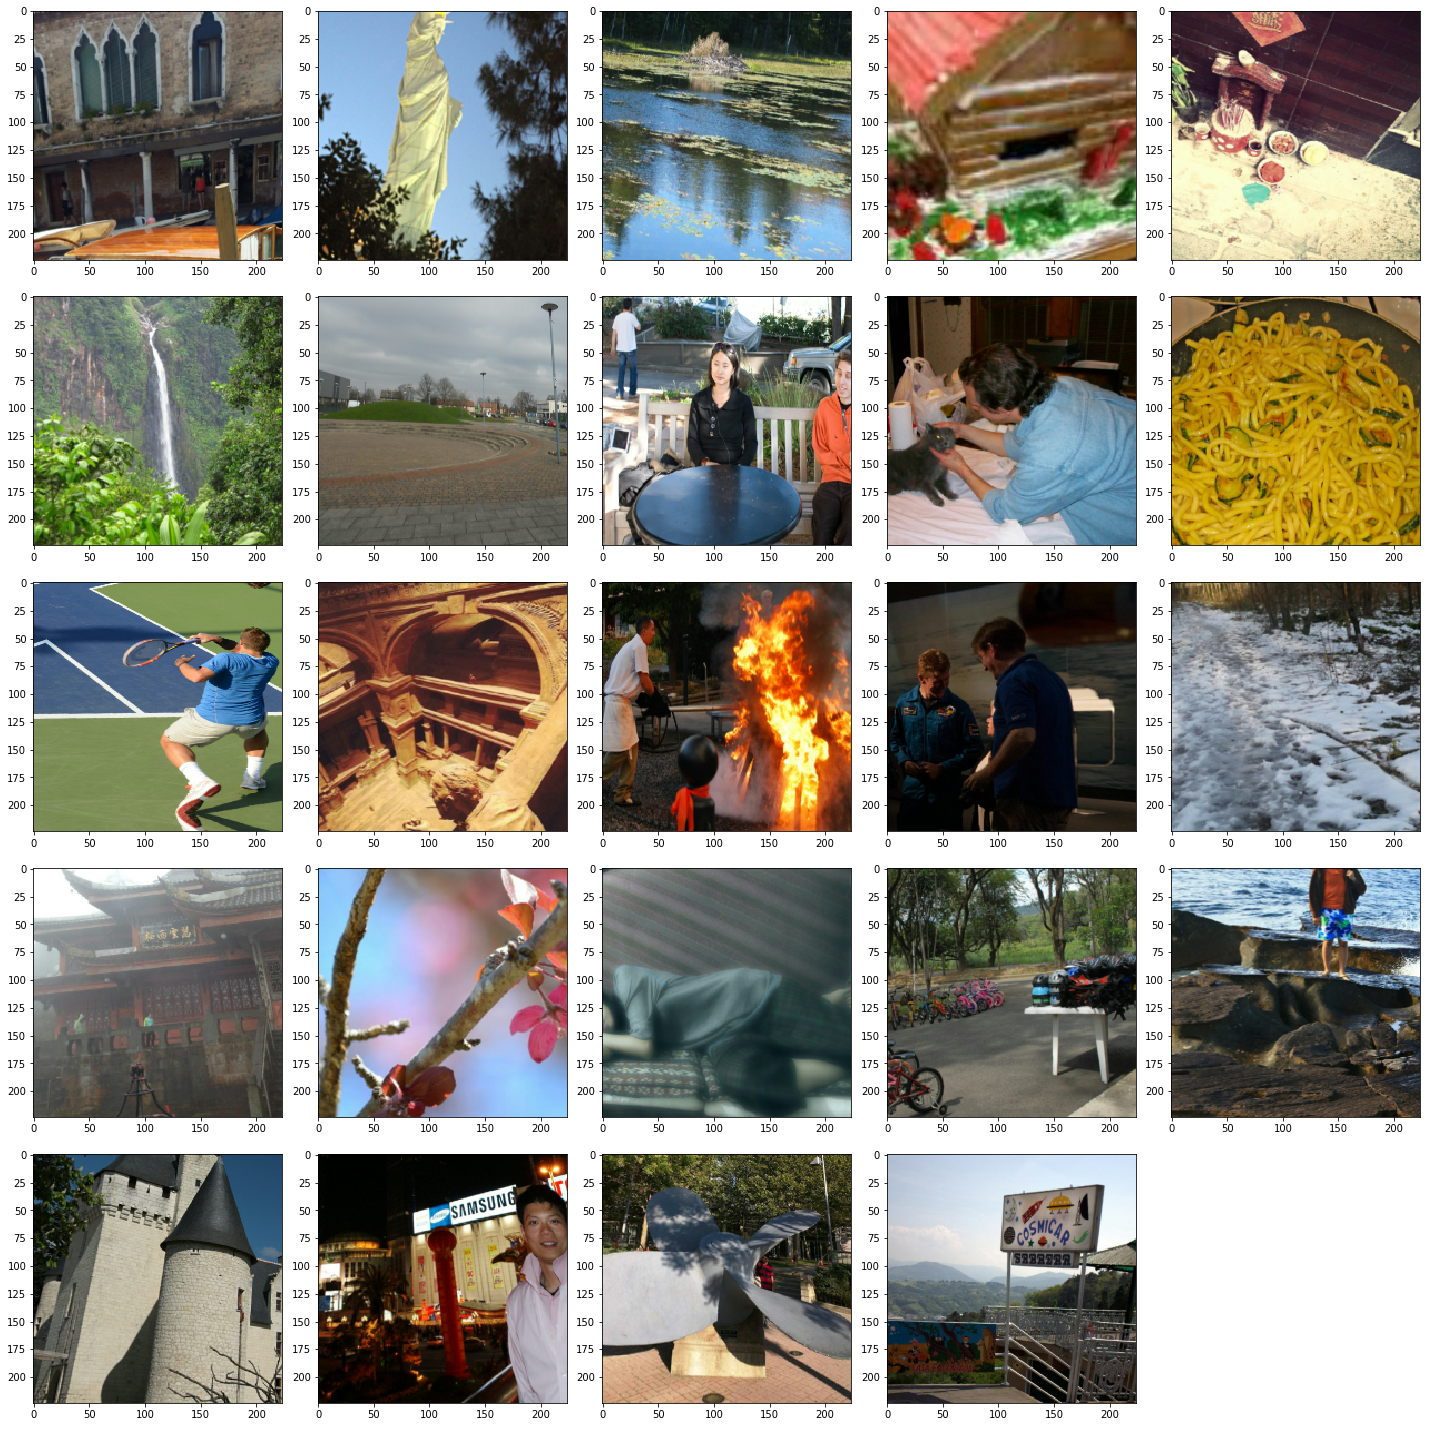

In [10]:
data.show_batch(20)
data.c=2

In [11]:
learn = unet_learner(data, models.resnet34, blur_final=False, y_range=(0,1.))
learn.unfreeze()

In [12]:
learn.load('w1')
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 112, 112]    9,408      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      36,864     True      
______________________________________________________________________
BatchNorm2d          [1, 64, 56, 56]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 56, 56]      0          False     
______________________________________________________________

# Skip to inference if you do not want to train

In [ ]:
lr_find(learn)
lr = learn.recorder.plot()

In [ ]:
learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.fit_one_cycle(2,max_lr=2e-5)

In [ ]:
learn.save('w1', return_path=True)

In [ ]:
learn.show_results(rows=20, figsize=(16,9*10))

# Inference

In [22]:
#y = get_Y('test/schindler.png')
y = get_Y('gwtw.jpg')
cbcr = Image(learn.predict(y.clone().resize(size))[1])
yCbCr = torch.cat([y.data[:1],cbcr.resize((2,y.shape[1],y.shape[2])).data])
np_yCbCr = np.transpose((yCbCr.cpu().numpy()*255).astype(np.uint8), (1,2,0))


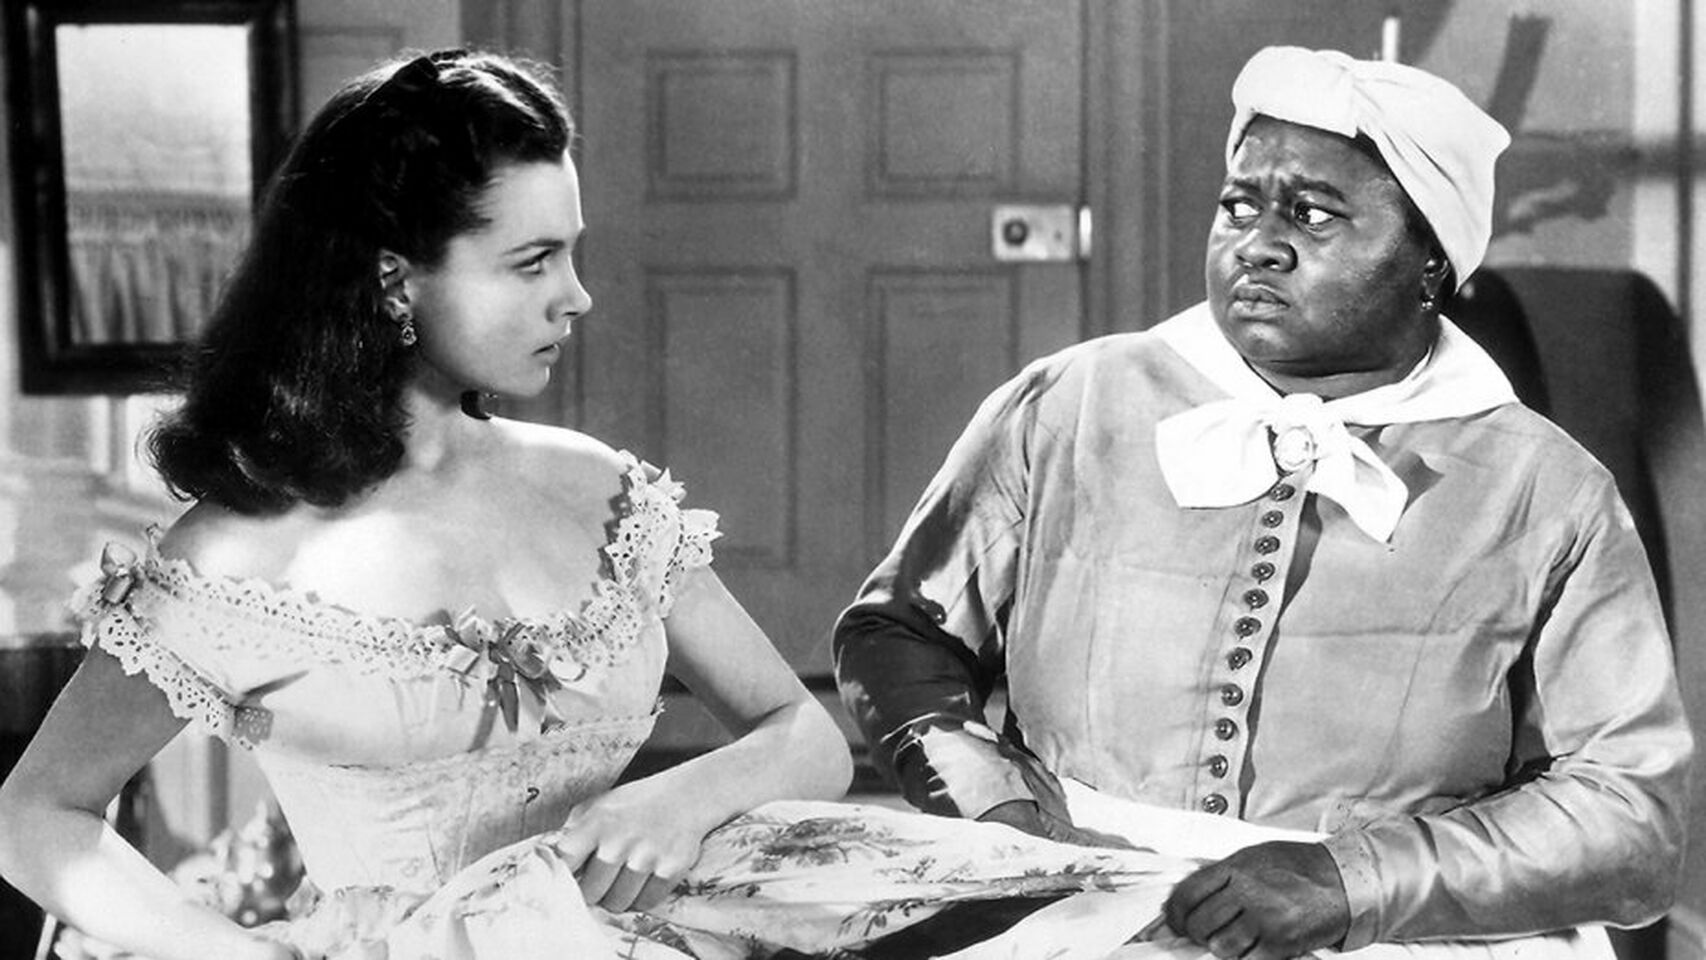

In [23]:
y

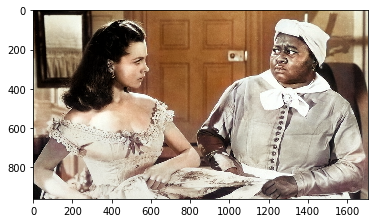

In [24]:
colorized = PIL.Image.fromarray(np_yCbCr, mode='YCbCr')
plt.imshow(colorized)

In [ ]:
colorized.save('twc.jpg')